# **EE5178: Panoramic Stitching**



# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping.

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors from two input images.

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_features

2. match_keypoints

3. find_homography and transform_ransac

4. panoramic_stitching

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount("/content/drive/")
import os
os.getcwd()
!mkdir MyDrive   # make a directory called MyDrive
!mount --bind /content/drive/My\ Drive /content/MyDrive

Mounted at /content/drive/


In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

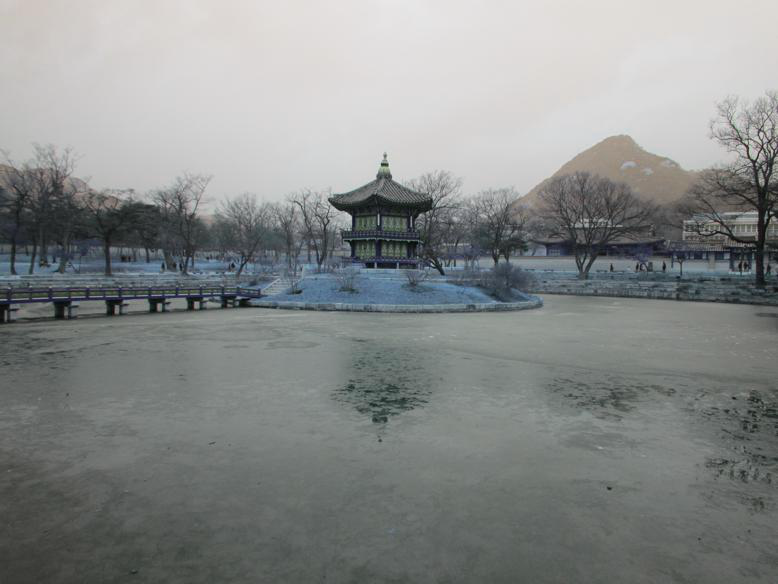

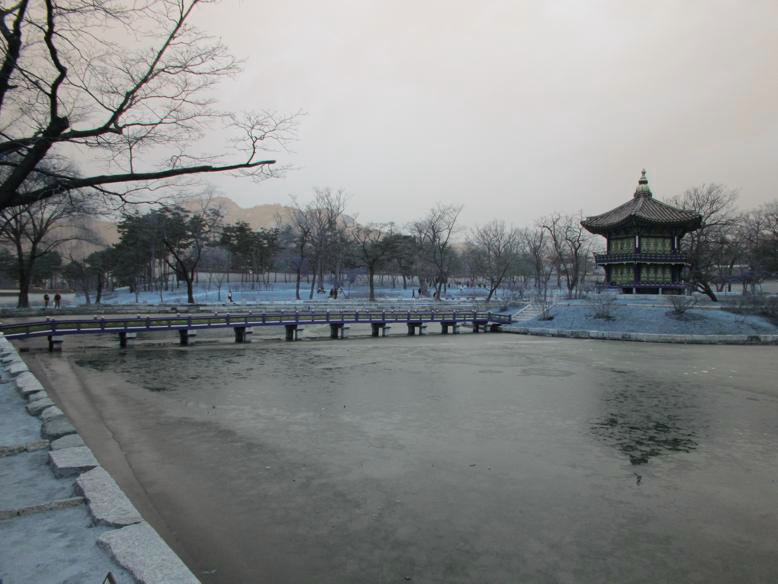

In [ ]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')
for i in range(0,2):
  if(i==1):
    cv2_imshow(img1)
  else:
    cv2_imshow(img2)

# Visualize Input Images

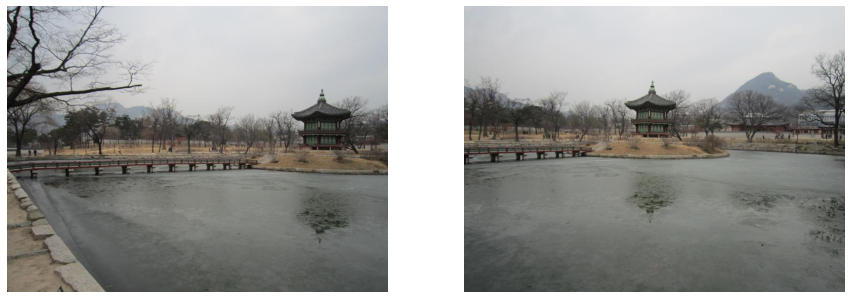

In [ ]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# Compute SURF/ SIFT/ ORB Features and Match Keypoints

In [ ]:
def get_features(img):
  '''
    Compute SURF/SIFT/ORB features using cv2 library functions. Use default parameters when computing the keypoints.
    Input:
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of feature descriptors
  '''
  # ===============================================
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(img, None)

  # ===============================================
  return (keypoints, descriptors)

def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  # ===============================================
  # TODO
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
  matches = bf.match(desc_1,desc_2)

  # ===============================================
  return matches


keypoints for img1 and img2


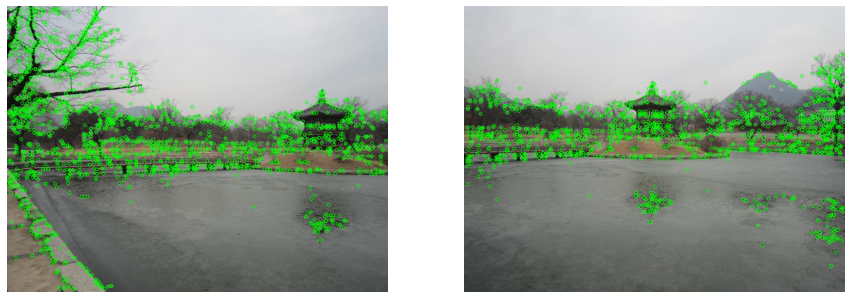

In [ ]:
kp_1, desc_1 = get_features(img1)
kp_2, desc_2 = get_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

feature matches


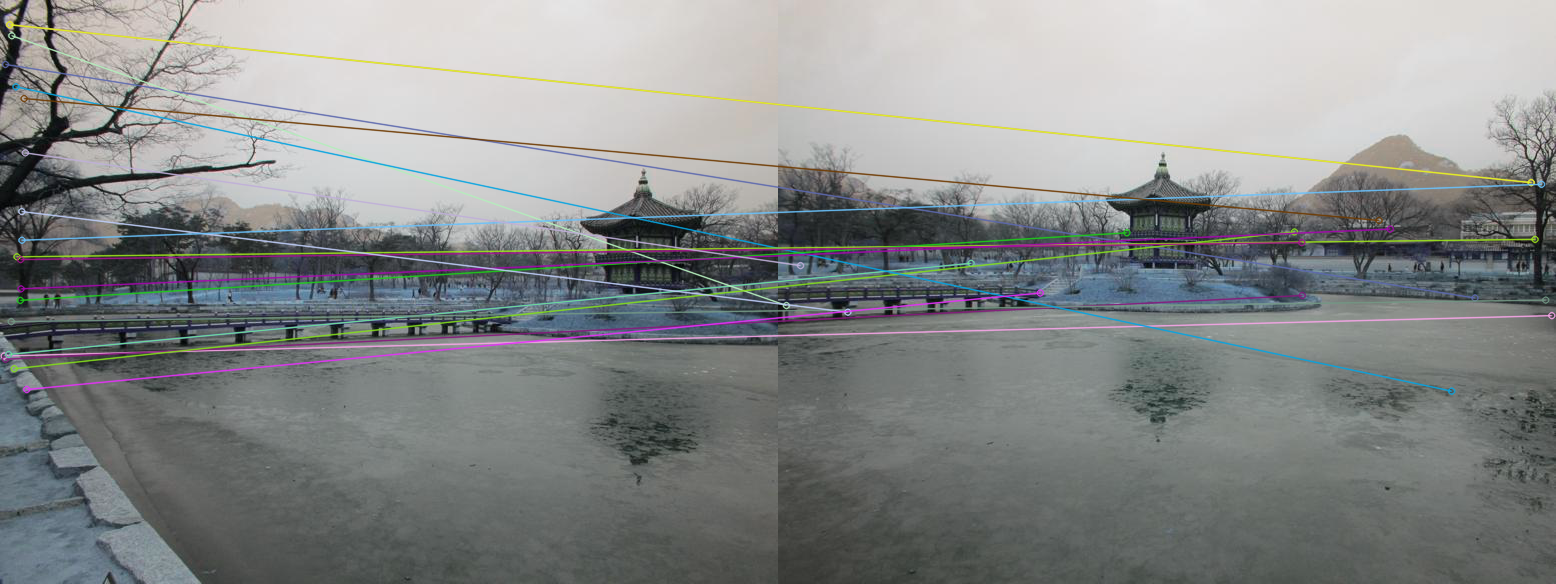

In [ ]:
# matches,raw_match = match_keypoints(desc_1, desc_2)
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("feature matches")
cv2_imshow(match_plot)

# Compute Homography Matrix using RANSAC

In [ ]:
def find_homography(pts_1, pts_2):
  '''
    Implement Direct Linear Transform to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Input:
      pts_1, pts_1: (N, 2) matrix
    Return:
      H: the resultant homography matrix (3 x 3)
  '''
  # ===============================================

  correspondenceList=[]
  for i in range(0,pts_1.shape[0]):
    correspondenceList.append([pts_1[i,0],pts_1[i,1],pts_2[i,0],pts_2[i,1]])
  corr = np.matrix(correspondenceList)


  #find 4 random points to calculate a homography
  corr1 = corr[random.randrange(0, len(corr))]
  corr2 = corr[random.randrange(0, len(corr))]
  randomFour = np.vstack((corr1, corr2))
  corr3 = corr[random.randrange(0, len(corr))]
  randomFour = np.vstack((randomFour, corr3))
  corr4 = corr[random.randrange(0, len(corr))]
  randomFour = np.vstack((randomFour, corr4))
  aList = []
  for ele in randomFour:
      p1 = np.matrix([ele.item(0), ele.item(1), 1])
      p2 = np.matrix([ele.item(2), ele.item(3), 1])

      a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
            p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
      a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
            p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
      aList.append(a1)
      aList.append(a2)
  matrixA = np.matrix(aList)

  #svd composition
  u, s, v = np.linalg.svd(matrixA)

  #reshape the min singular value into a 3 by 3 matrix
  H = np.reshape(v[8], (3, 3))

  #normalize and now we have h
  H = (1/H.item(8)) * H
  # ===============================================
  return H,corr

In [ ]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


In [ ]:
def transform_ransac(pts_1, pts_2):
  '''
    Implement RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
  '''
  # ===============================================
  maxInliers = []
  finalH = None
  thresh=0.60
  for i in range(1000):

      #call the homography function on those points
      h,corrs = find_homography(pts_1,pts_2)
      inliers = []

      for i in range(len(corrs)):
          d = geometricDistance(corrs[i], h)
          if d < 50:
              inliers.append(corrs[i])

      if len(inliers) > len(maxInliers):
          maxInliers = inliers
          finalH = h
  print("Corr size: ", len(corrs), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))


  # return finalH, maxInliers
  best_model=finalH
  # ===============================================
  return best_model

In [ ]:
def getHomography(img1, img2,x_offset,y_offset):
  kp_1, desc_1 = get_features(img1)
  kp_2, desc_2 = get_features(img2)
  matches = match_keypoints(desc_1, desc_2)
  keypoints = [kp_1,kp_2]
  pts_1=[]
  pts_2=[]
  for match in matches:
    (x1, y1) = keypoints[0][match.queryIdx].pt
    (x2, y2) = keypoints[1][match.trainIdx].pt
    pts_1.append([x1,y1])
    pts_2.append([x2,y2])

  pts_1M=np.matrix(pts_1)
  pts_2M=np.matrix(pts_2)
  finalH = transform_ransac(pts_1M, pts_2M)
  # x_offset= 200
  # y_offset= 10
  offset_matrix=np.matrix([[ 1 , 0 , x_offset],[ 0 , 1 , y_offset],[ 0 , 0 ,    1    ]])
  M=np.matmul(finalH,offset_matrix)
  result = cv2.warpPerspective(img1, M,(img1.shape[1] + img2.shape[1], img1.shape[0]))
  return result,M

# Panoramic Stitching

In [ ]:
def panoramic_stitching(img1, img2,sideOffset1,sideOffset2):
  '''
    Generate a panoramic image using the obtained homography matrix.
    Input:
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  # ===============================================
  result1,H1=getHomography(img1,img2,250,10)
  result2,H2=getHomography(img2,img1,-100,0)

  imgs=[result1[:,:sideOffset1],result2[:,sideOffset2:]]
  stitchy=cv2.Stitcher.create()
  (dummy,final_img)=stitchy.stitch(imgs)

  if dummy != cv2.STITCHER_OK:
    # checking if the stitching procedure is successful
    # .stitch() function returns a true value if stitching is
    # done successfully
      print("stitching ain't successful")
  else:
      print('Your Panorama is ready!!!')
    # ===============================================
  return result1,result2,final_img,H1,H2

Corr size:  686  NumInliers:  72 Max inliers:  427
Corr size:  686  NumInliers:  26 Max inliers:  427
Your Panorama is ready!!!


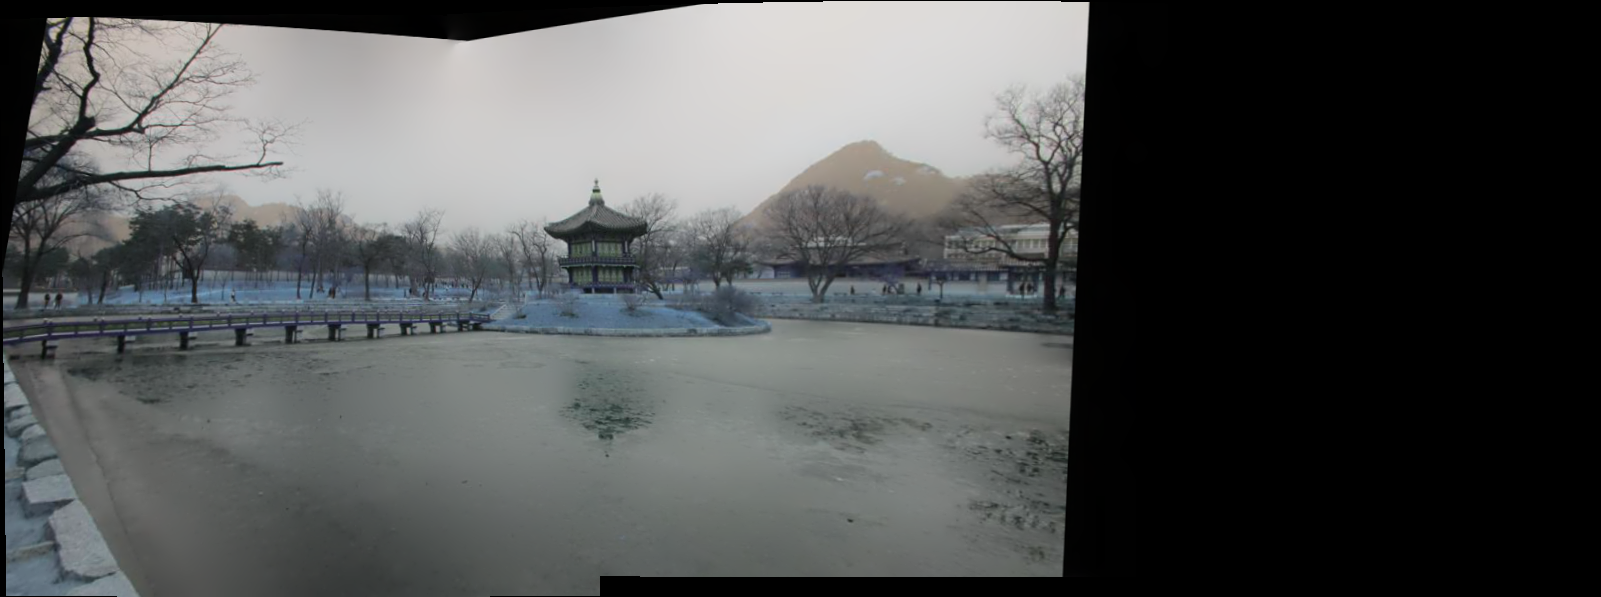

In [ ]:
k,l,resultp,h1,h2 = panoramic_stitching(img1, img2,600,200)

# print(resultp.shape)
cv2_imshow(resultp)

In [ ]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    print(h1, w1)
    print(h2, w2)
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

In [ ]:
# plt.figure(figsize = (8,8))
# plt.imshow(warpTwoImages(img1,img2,h2),cmap='gray')
# plt.show()

584 778
584 778


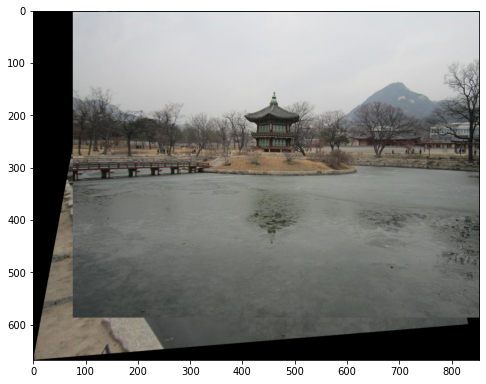

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(warpTwoImages(img2,img1,h1),cmap='gray')
plt.show()

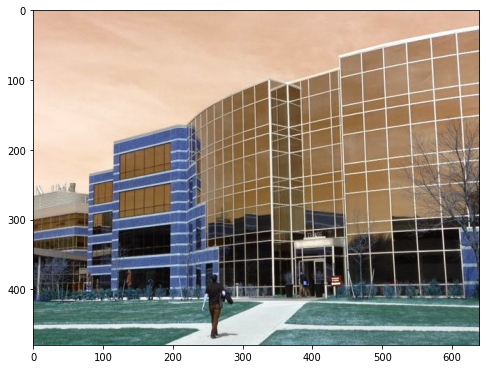

In [ ]:
image1 = cv2.imread('/content/MyDrive/ColabNotebooks/Assignment4/data_n_3/image1.jpg') #Importing the Image from Colab temporary files ,Converting into gray scale using opencv
image2 = cv2.imread('/content/MyDrive/ColabNotebooks/Assignment4/data_n_3/image2.jpg')
image3 = cv2.imread('/content/MyDrive/ColabNotebooks/Assignment4/data_n_3/image3.jpg')
gray_image = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
# print(gray_image.dtype)
plt.figure(figsize = (8,8))
plt.imshow(image1,cmap='gray')
plt.show()

Corr size:  1075  NumInliers:  936 Max inliers:  938
Corr size:  1075  NumInliers:  936 Max inliers:  939
Your Panorama is ready!!!
480 640
480 640


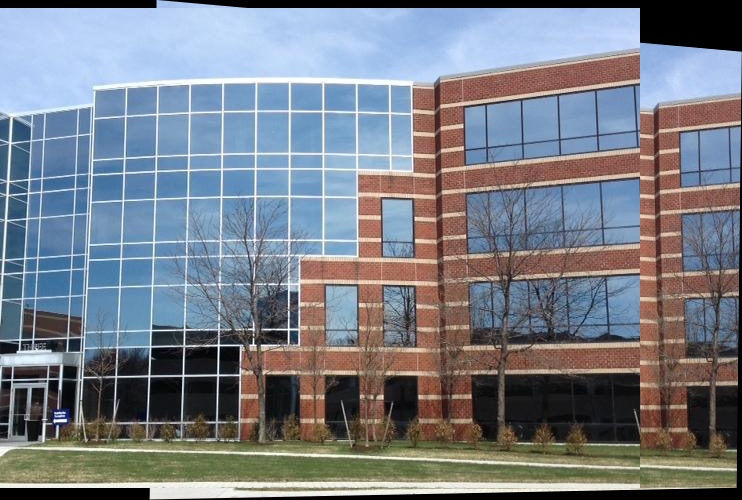

In [ ]:
a,b,result2,h11,h12 = panoramic_stitching(image2, image3,700,200)
CONCAT1=warpTwoImages(image3,image2,h11)
cv2_imshow(CONCAT1)

Corr size:  758  NumInliers:  45 Max inliers:  439
Corr size:  758  NumInliers:  47 Max inliers:  437
Your Panorama is ready!!!
500 742
480 640


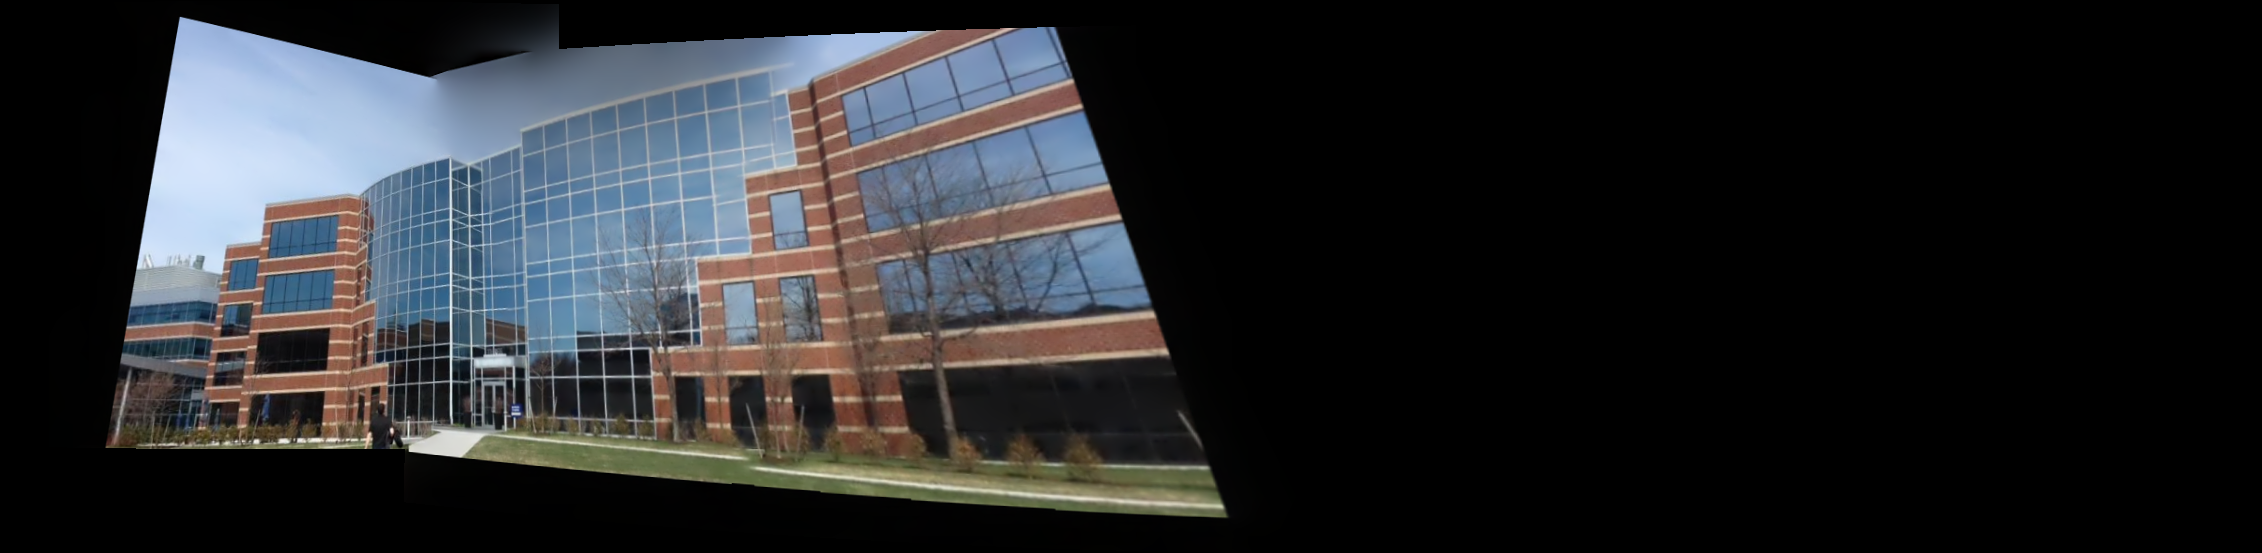

In [ ]:
d,e,final,h21,h22 = panoramic_stitching(image1,result2,600,200)
concat2=warpTwoImages(CONCAT1,image1,h21)
cv2_imshow(final)